# Introducción a la API de tf.keras

# Introducción a Keras LSTM para series de tiempo univariadas

## Autor

1. Alvaro Mauricio Montenegro Díaz, ammontenegrod@unal.edu.co
2. Daniel Mauricio Montenegro Reyes, dextronomo@gmail.com 

## References

1. [Introducción a Redes LSTM](Intro_LSTM.ipynb)
2. [Time Series Forecasting with LSTMs using TensorFlow 2 and Keras in Python](https://towardsdatascience.com/time-series-forecasting-with-lstms-using-tensorflow-2-and-keras-in-python-6ceee9c6c651/)

# Introducción

Los datos de la serie temporal introducen una "dependencia dura" de los pasos de tiempo anteriores, por lo que no se cumple la independencia de las observaciones. ¿Cuáles son algunas de las propiedades que puede tener una serie temporal?

La *estacionalidad*, la *estacionalidad* y la *autocorrelación* son algunas de las propiedades de la serie temporal en las que puede estar interesado.

Se dice que una serie de tiempos es **estacionaria** cuando la media y la varianza permanecen constantes en el tiempo. 

Una serie temporal tiene una **tendencia** si la media varía con el tiempo. A menudo puede eliminarlo y hacer que la serie sea estacionaria aplicando transformación(es) logarítmicas de los datos.


**La estacionalidad** se refiere al fenómeno de las variaciones en plazos específicos. por ejemplo, personas que compran más árboles de Navidad durante Navidad (quién lo hubiera pensado). Un enfoque común para eliminar la estacionalidad es usar la diferenciación.

**La autocorrelación** se refiere a la correlación entre el valor actual con una copia de un tiempo anterior (retraso).  

Usaremos redes neuronales para el modelamiento de esta series.

# Modelo LSTM

Este código puede ser usado como base para la impelemntación de modelos mas complejos. Para un introdución teórica a las redes LSTM consulte el cuaderno [Redes LSTM (Long Short Term Memory Networks)](Intro_LSTM.ipynb)


# Predicción de series de tiempo con redes LSTM

Comenzaremos con un ejemplo simple de pronosticar los valores de la función Seno utilizando una red LSTM simple.

## Importar módulos requeridos

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

import tensorflow as tf
import numpy as np
from tensorflow import keras
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))

print("Versión de Tensorflow: ", tf.__version__)

Versión de Tensorflow:  2.1.0


## Configuraciones básicas generales

In [2]:
%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.5)

rcParams['figure.figsize'] = 16, 10

RANDOM_SEED = 42

np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

trend = .1

## Datos sintéticos

In [3]:
time = np.arange(0, 100, 0.1)
sin = trend*time + np.sin(time) + np.random.normal(scale=0.5, size=len(time))

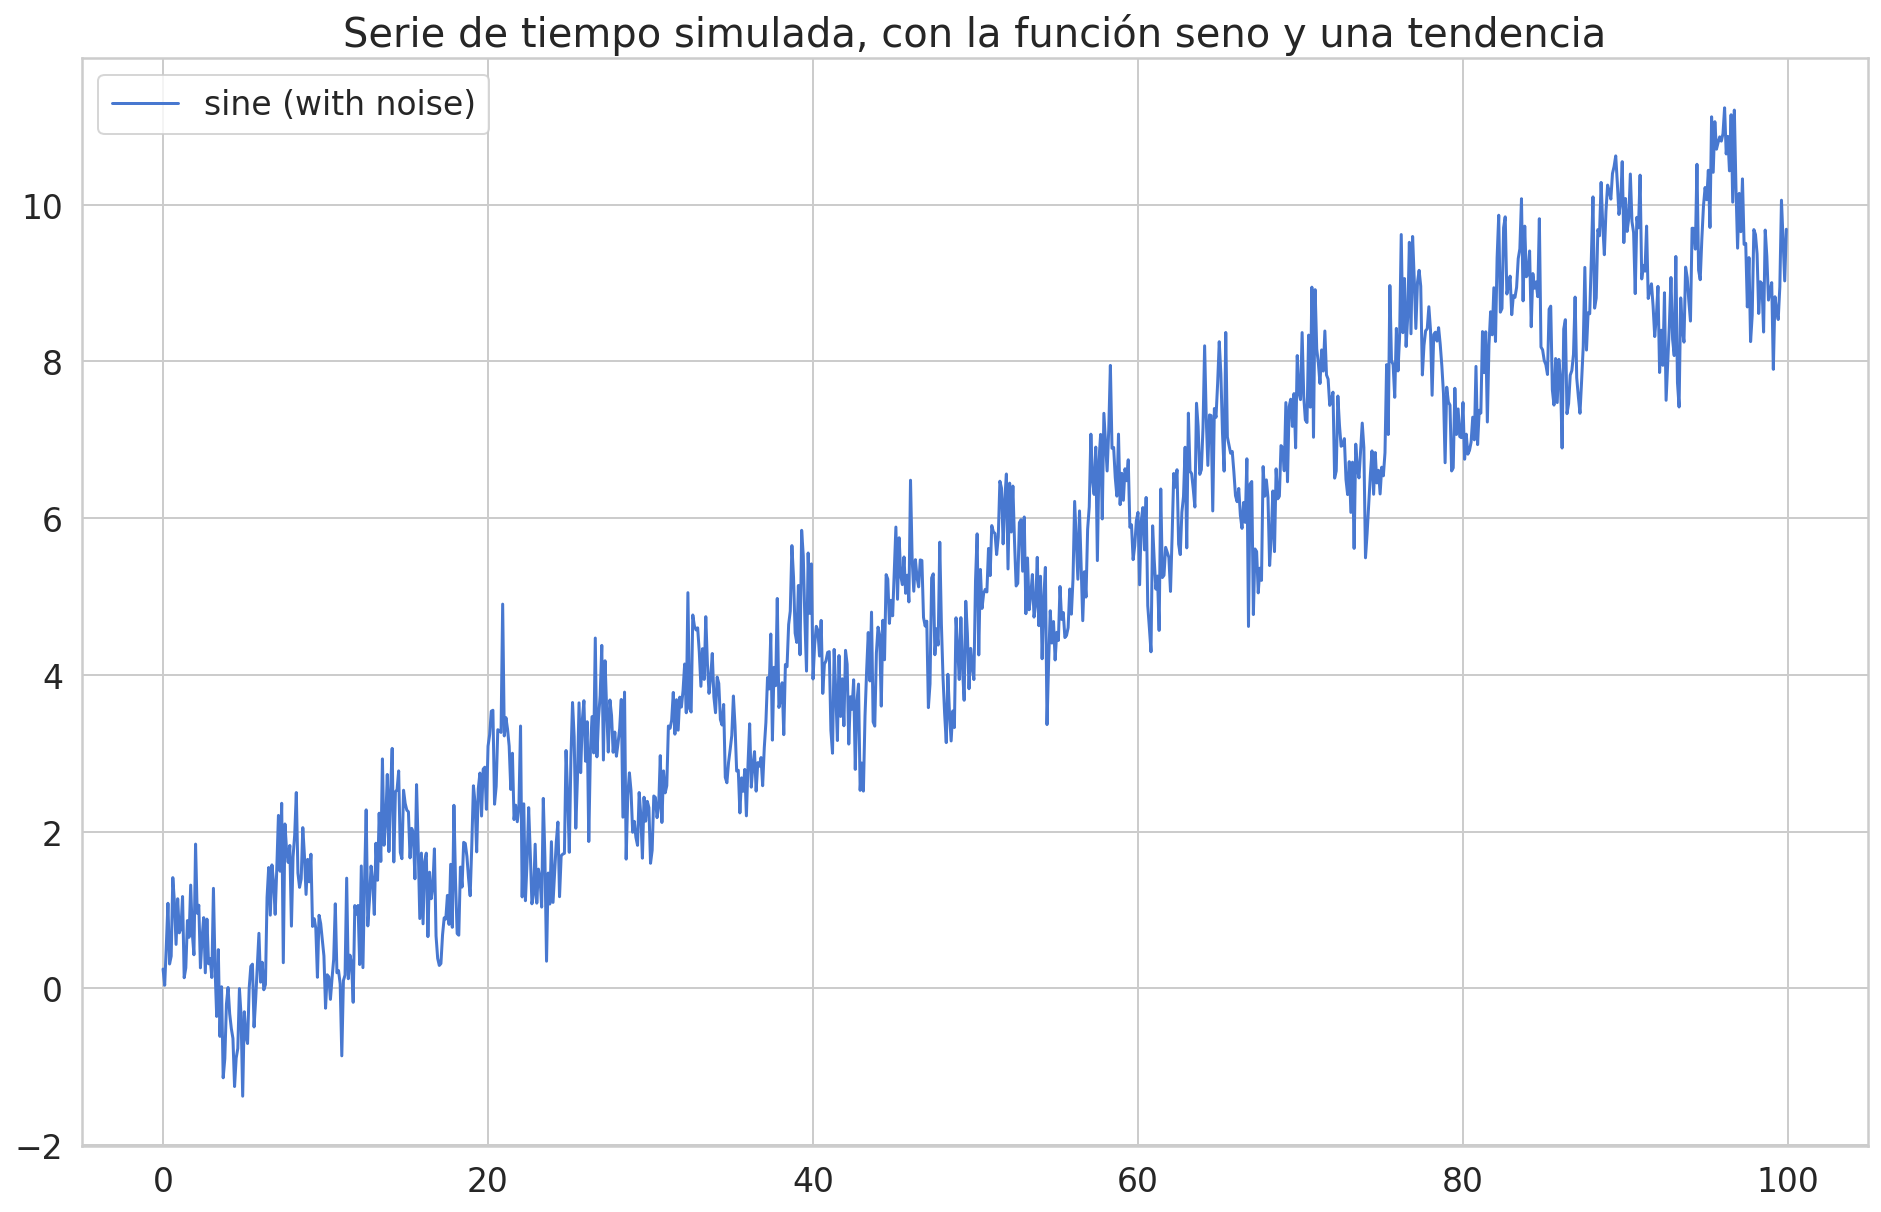

In [4]:
plt.plot(time, sin, label='sine (with noise)');
plt.title("Serie de tiempo simulada, con la función seno y una tendencia", size = 20)
plt.legend();
plt.show()


Se agrega un valor aleatorio, extraído de una distribución normal, a cada punto de datos. Eso hará que el trabajo de nuestro modelo sea un poco más difícil. Adicionalmente se ha adicionado una tendencia de tipo lineal.

## Escalación de los datos

In [5]:
#creating train and test sets
df = pd.DataFrame(dict(sine=sin), index=time, columns=['sine'])
#dataset = df.values

# create the scaler object and scale the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(df.values)
dataset = pd.DataFrame(scaled_data)
dataset.columns = ['sine']
dataset.index = df.index

##  Separación de datos entrenamiento y de validación

Necesitamos "cortar los datos" en secuencias más pequeñas para nuestro modelo. Pero primero, lo dividiremos en datos de entrenamiento y prueba:

In [6]:
train_size = int(len(dataset) * 0.8)
test_size = len(dataset) - train_size
train, test = dataset.iloc[0:train_size], dataset.iloc[train_size:len(df)]
len_train = len(train)
len_test = len(test)
print(len_train, len_test)

800 200


In [7]:
dataset.head()

,sine
0.0,0.128662
0.1,0.112194
0.2,0.151991
0.3,0.195175
0.4,0.133737


## Plot que muestra los datos de entrenamiento y los de validación

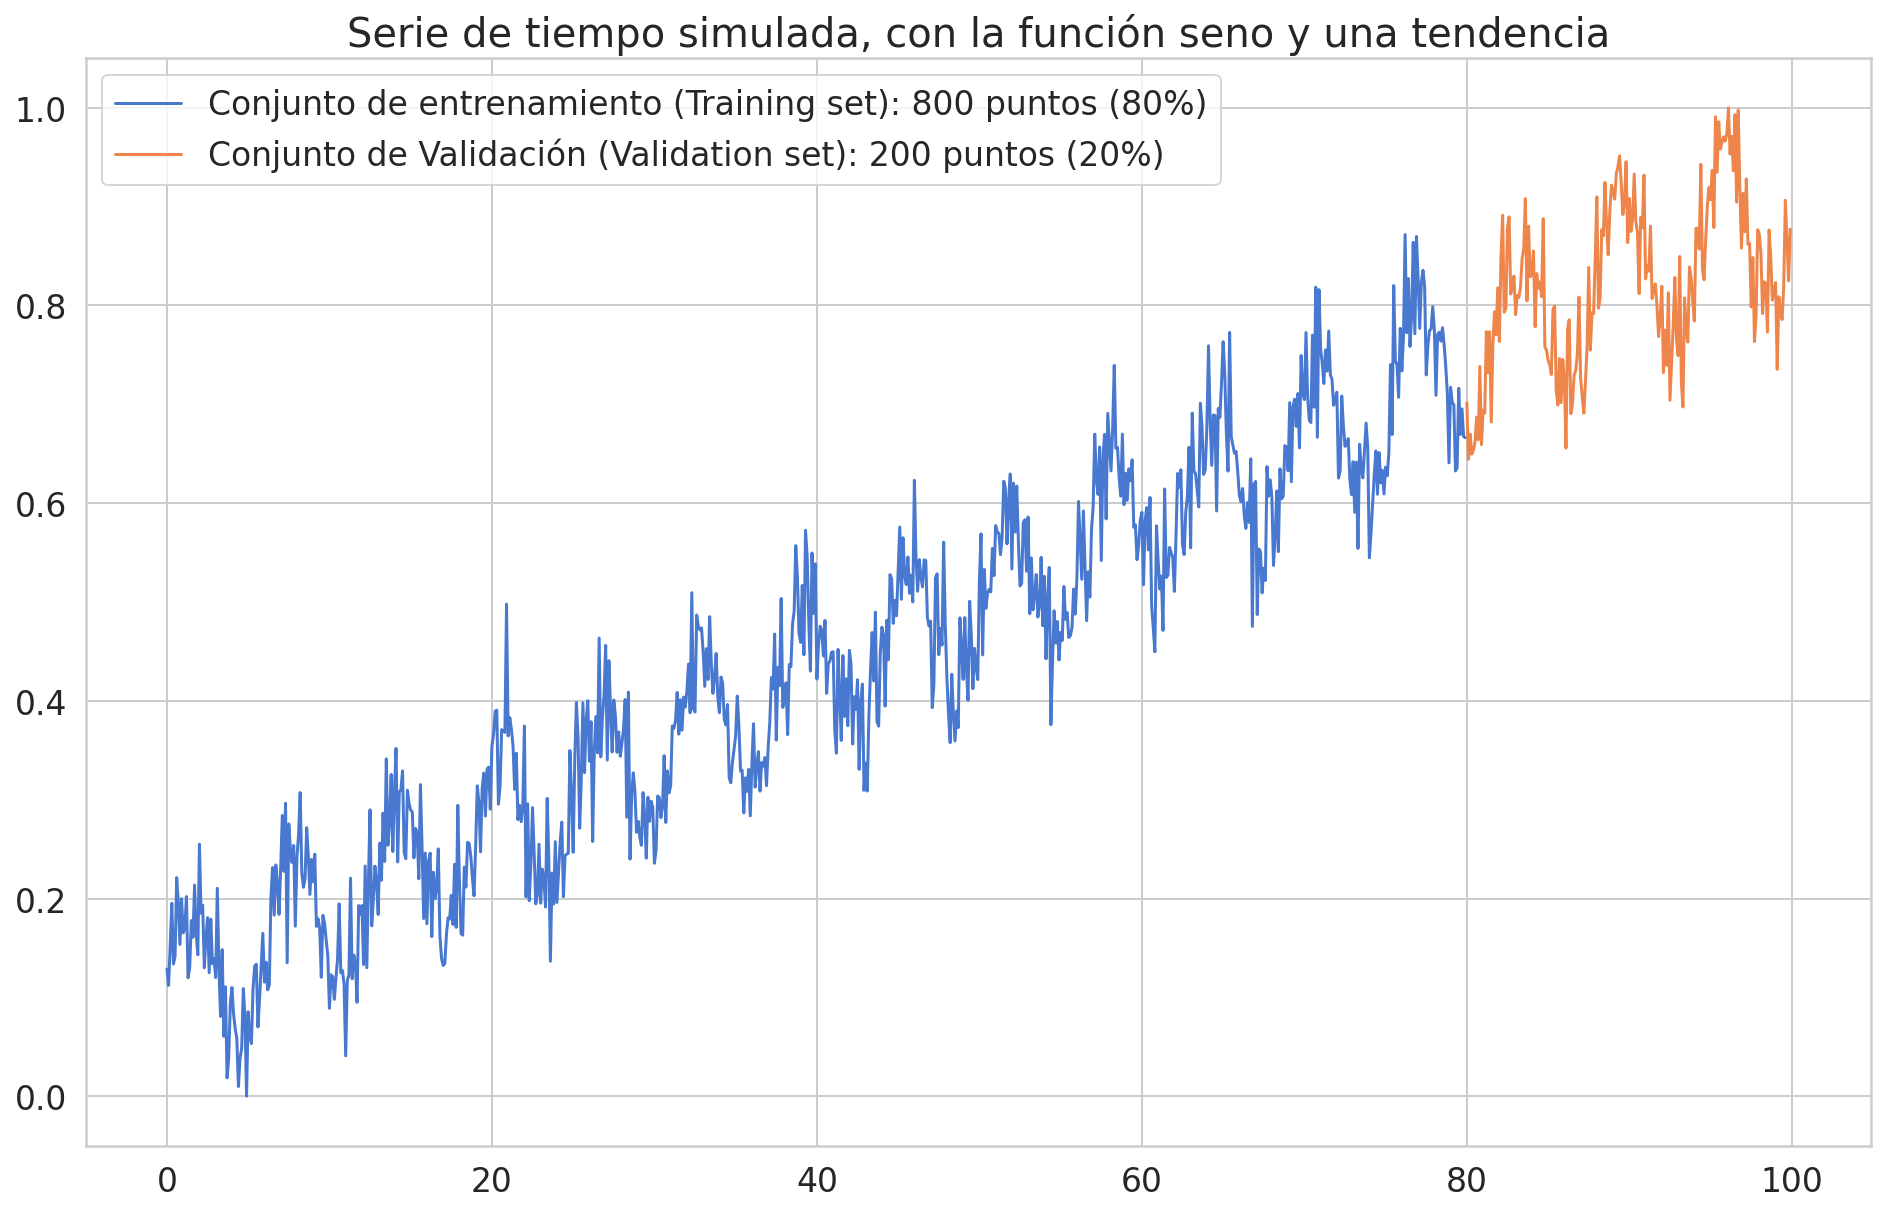

In [8]:
#plt.figure(figsize=(16,8))
plt.plot(train, label='Conjunto de entrenamiento (Training set): ' + str(len_train) +' puntos (80%)')
plt.plot(test, label='Conjunto de Validación (Validation set): '  + str(len_test) + ' puntos (20%)') 
plt.title("Serie de tiempo simulada, con la función seno y una tendencia", size = 20)
plt.legend()
plt.show()

Preparar los datos para la predicción de series temporales (LSTM en particular) puede ser complicado.

Intuitivamente, necesitamos predecir el valor en el paso de tiempo actual utilizando el historial ($n$ pasos de tiempo a partir de él). Aquí hay una función genérica que hace el trabajo

In [9]:
def create_dataset(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        v = X.iloc[i:(i + time_steps)].values
        Xs.append(v)
        ys.append(y.iloc[i + time_steps])
    return np.array(Xs), np.array(ys)

La belleza de esta función es que funciona con datos de series temporales univariadas (función única) y multivariadas (funciones múltiples). Usemos un historial de 20 pasos de tiempo para hacer nuestras secuencias:

In [10]:
time_steps = 50

# reshape to [samples, time_steps, n_features]

X_train, y_train = create_dataset(train, train.sine, time_steps)
X_test, y_test = create_dataset(test, test.sine, time_steps)

print(X_train.shape, y_train.shape)

(750, 50, 1) (750,)


## Modelamiento


Entrenar un modelo LSTM en Keras es fácil. Utilizaremos la capa LSTM en un modelo secuencial para hacer nuestras predicciones:

### Crea el modelo

In [34]:
lstm_output =60
model = keras.Sequential()
model.add(keras.layers.LSTM(units=lstm_output,  input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(keras.layers.Dense(units=1))

In [30]:
X_train.shape

(750, 50, 1)

Significa que el modelo tiene la primera de tipo LSTM capa con un input de tamaño $(750,50)$ y una salida de 50 neuronas.

La segunda es una capa densa con entreda 50 y salida una neurona

### Compila

In [31]:
model.compile(loss='mean_squared_error',
  optimizer=keras.optimizers.Adam(0.001)
)

### summary del modelo

El cálculo del número de neuronas es como sigue: 

$$
\text{Número de parámetros capa LSTM } = 4(p^2+ pn +p)
$$

en donde $p$ es el tamaño de salida y $n$ el tamaño de entrada.

In [28]:
4*(lstm_output*lstm_output + lstm_output*time_steps+ lstm_output)

26640

In [35]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 60)                14880     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 61        
Total params: 14,941
Trainable params: 14,941
Non-trainable params: 0
_________________________________________________________________


## Entrenamiento

Lo más importante para recordar al entrenar modelos de series temporales es no mezclar los datos (el orden de los datos es importante). El resto es bastante estándar:

In [16]:
history = model.fit(
    X_train, y_train,
    epochs=30,
    batch_size=16,
    validation_split=0.1,
    verbose=1,
    shuffle=False
)

Train on 675 samples, validate on 75 samples
Epoch 1/30
675/675 [==============================] - 8s 12ms/sample - loss: 0.0081 - val_loss: 0.0035
Epoch 2/30
675/675 [==============================] - 2s 3ms/sample - loss: 0.0056 - val_loss: 0.0032
Epoch 3/30
675/675 [==============================] - 2s 3ms/sample - loss: 0.0043 - val_loss: 0.0026
Epoch 4/30
675/675 [==============================] - 2s 4ms/sample - loss: 0.0033 - val_loss: 0.0025
Epoch 5/30
675/675 [==============================] - 2s 3ms/sample - loss: 0.0028 - val_loss: 0.0023
Epoch 6/30
675/675 [==============================] - 2s 3ms/sample - loss: 0.0025 - val_loss: 0.0021
Epoch 7/30
675/675 [==============================] - 2s 3ms/sample - loss: 0.0024 - val_loss: 0.0019
Epoch 8/30
675/675 [==============================] - 2s 3ms/sample - loss: 0.0024 - val_loss: 0.0019
Epoch 9/30
675/675 [==============================] - 2s 3ms/sample - loss: 0.0024 - val_loss: 0.0018
Epoch 10/30
675/675 [===============

## Evaluación

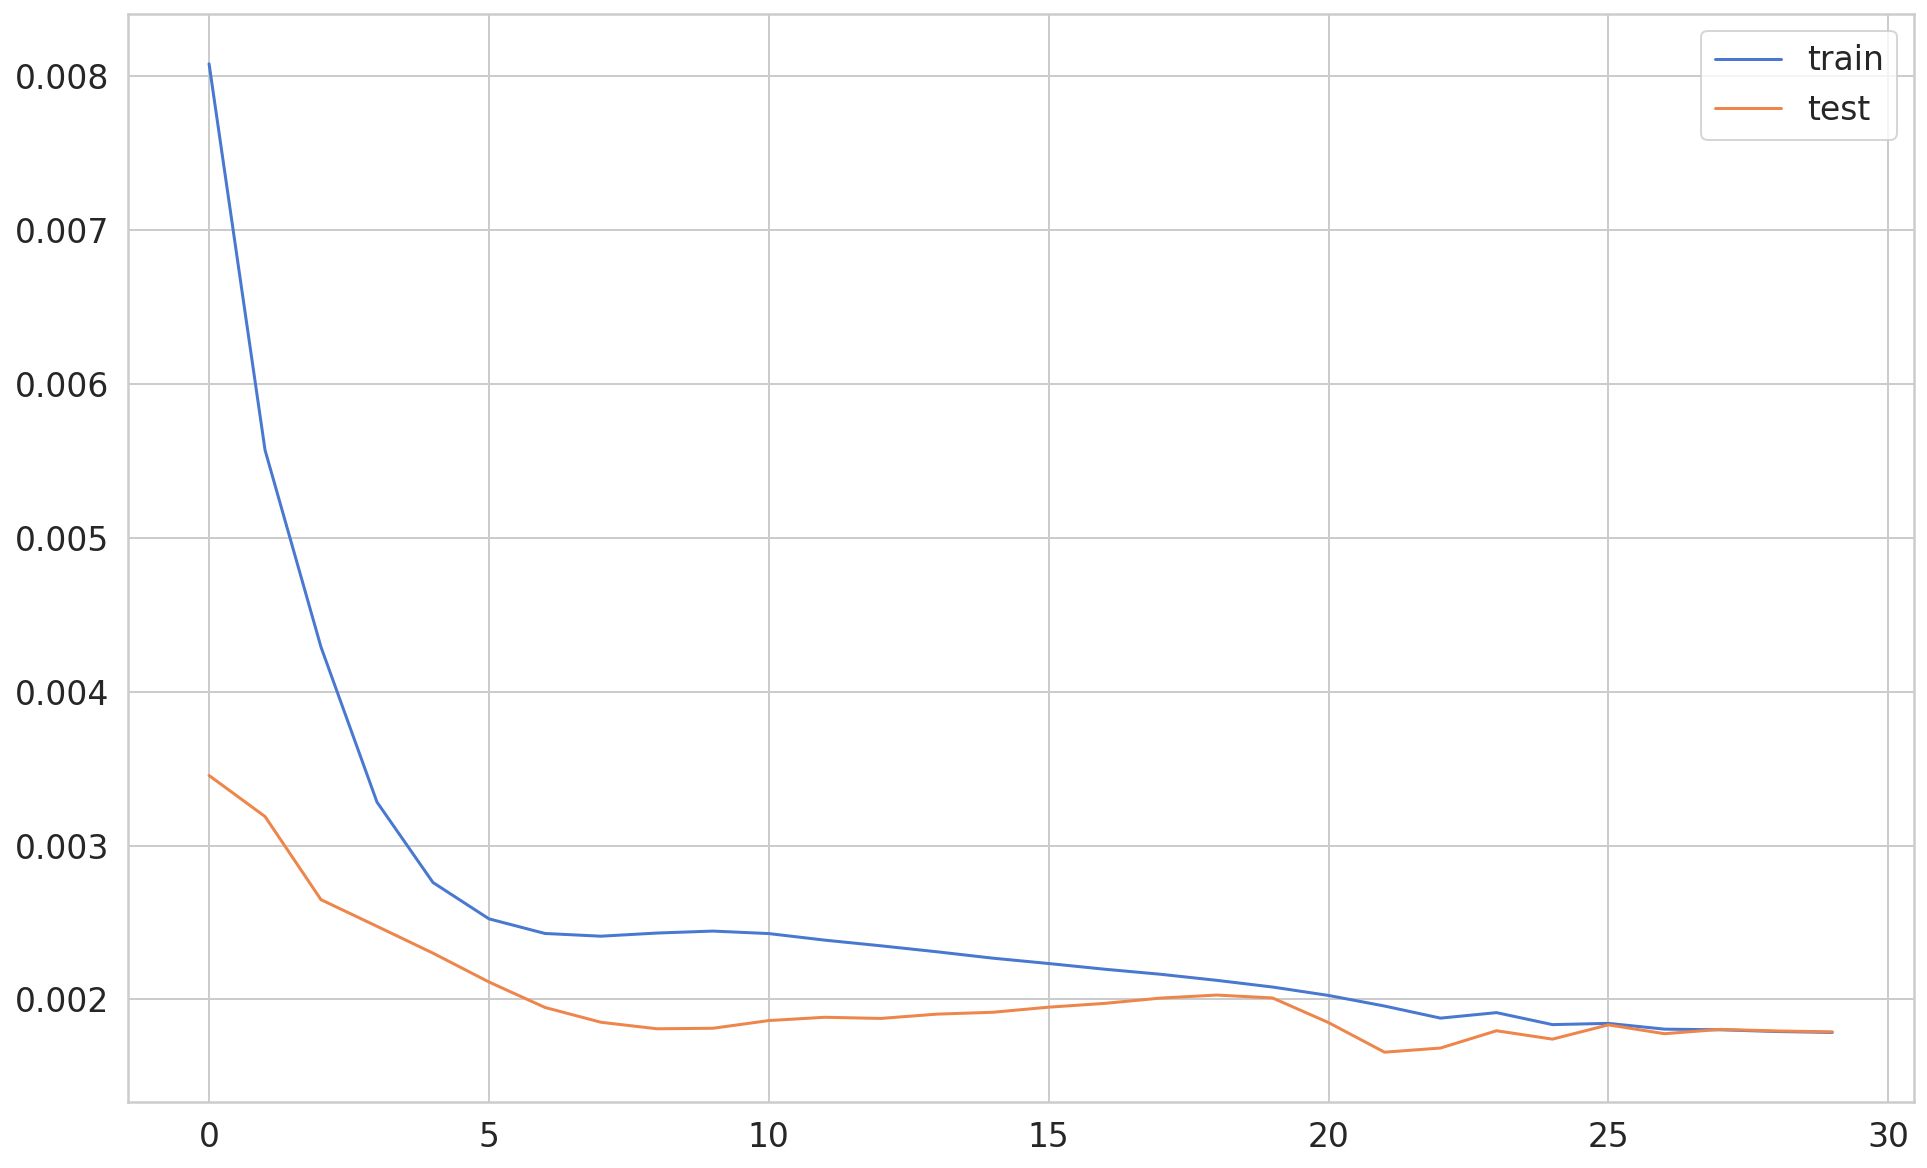

In [17]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend();

In [18]:
y_pred = model.predict(X_test)

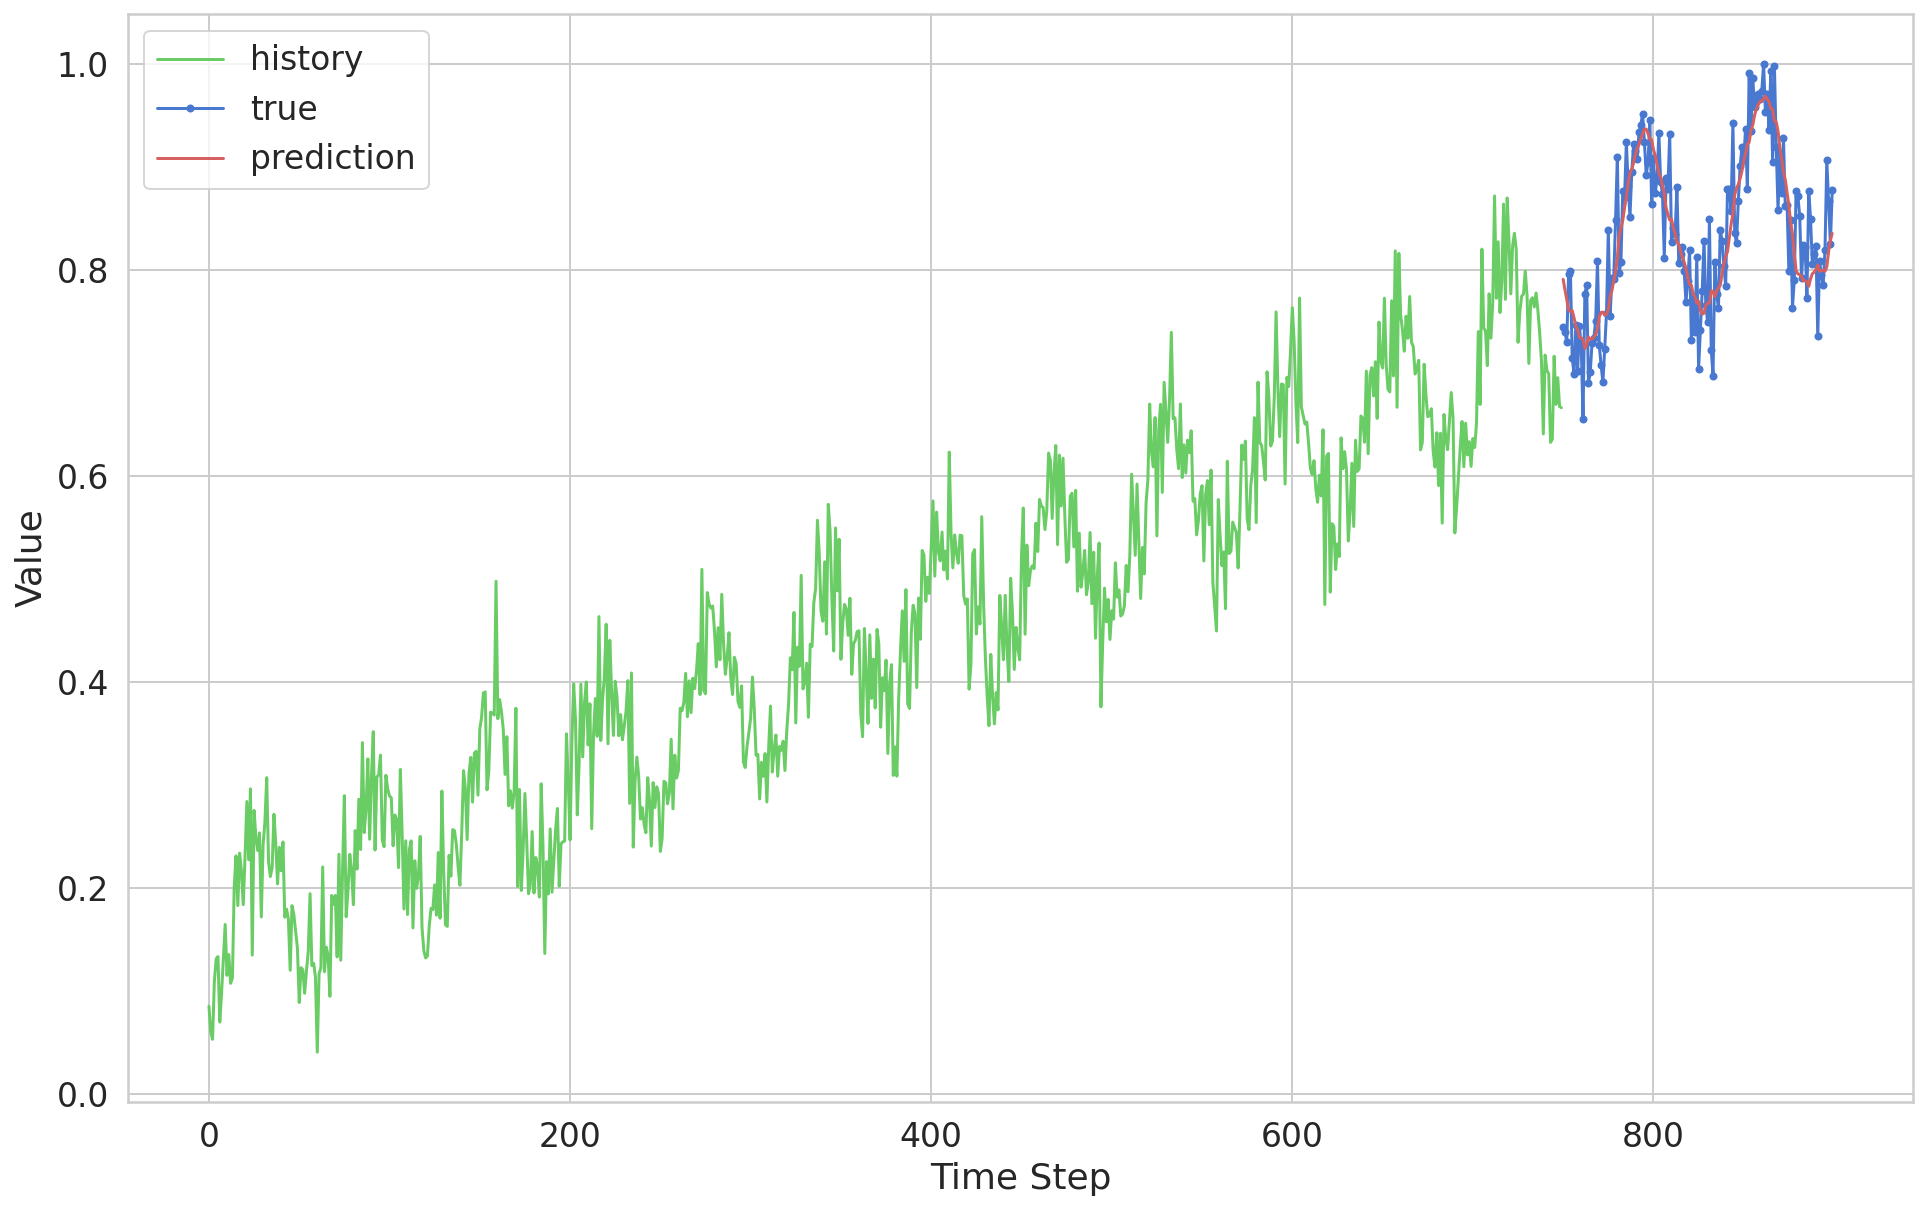

In [19]:
plt.plot(np.arange(0, len(y_train)), y_train, 'g', label="history")
plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), y_test, marker='.', label="true")
plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), y_pred, 'r', label="prediction")
plt.ylabel('Value')
plt.xlabel('Time Step')
plt.legend()
plt.show();

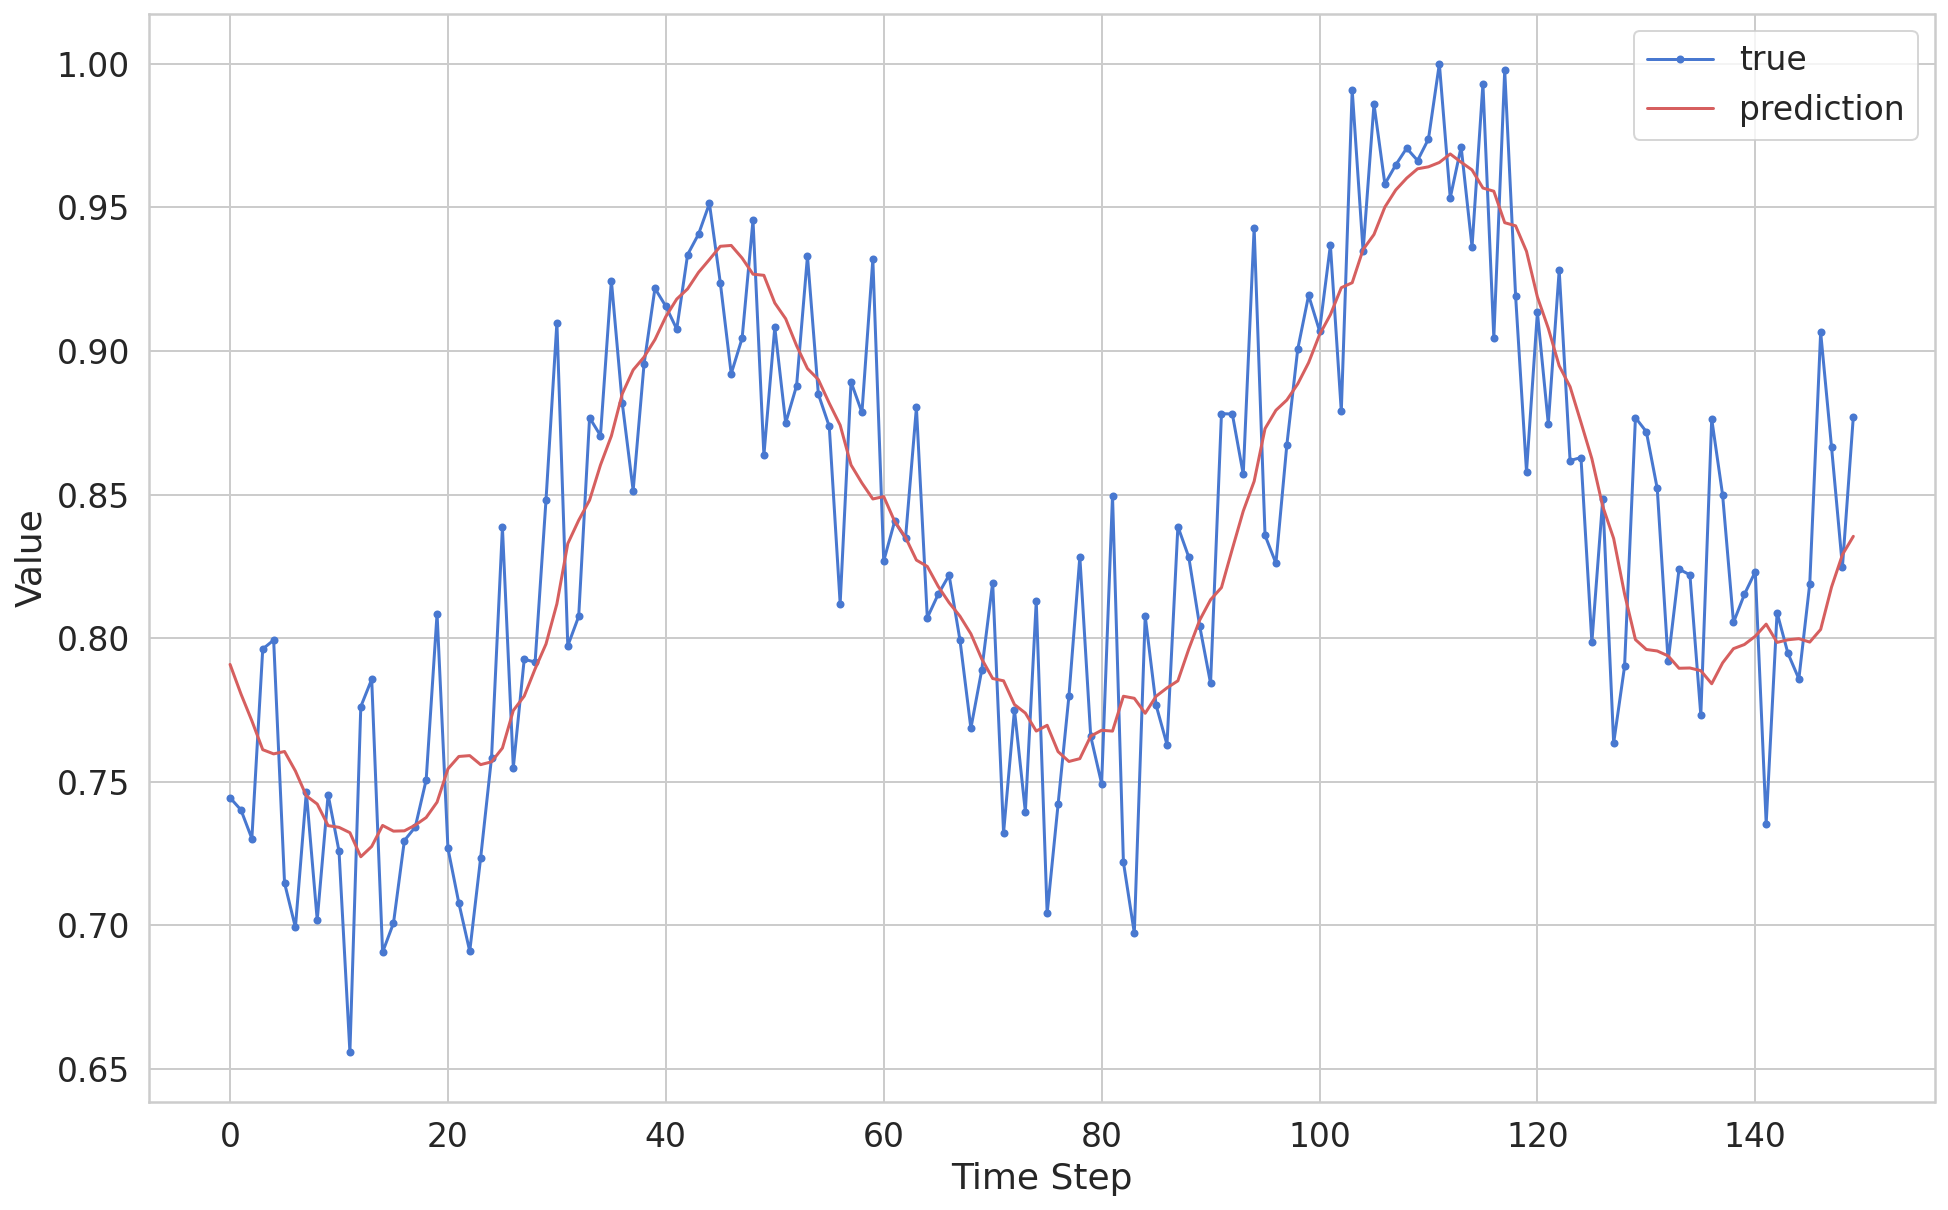

In [20]:
plt.plot(y_test, marker='.', label="true")
plt.plot(y_pred, 'r', label="prediction")
plt.ylabel('Value')
plt.xlabel('Time Step')
plt.legend()
plt.show();

## Transforma a la escala original

In [21]:
scaled_data = scaler.fit_transform(df.values)
dataset = pd.DataFrame(scaled_data)
dataset.columns = ['sine']
dataset.index = df.index

In [22]:
y_pred = scaler.inverse_transform(y_pred)


In [23]:
y_test = scaler.inverse_transform(y_test.reshape(-1,1))

In [24]:
y_pred.shape

(150, 1)

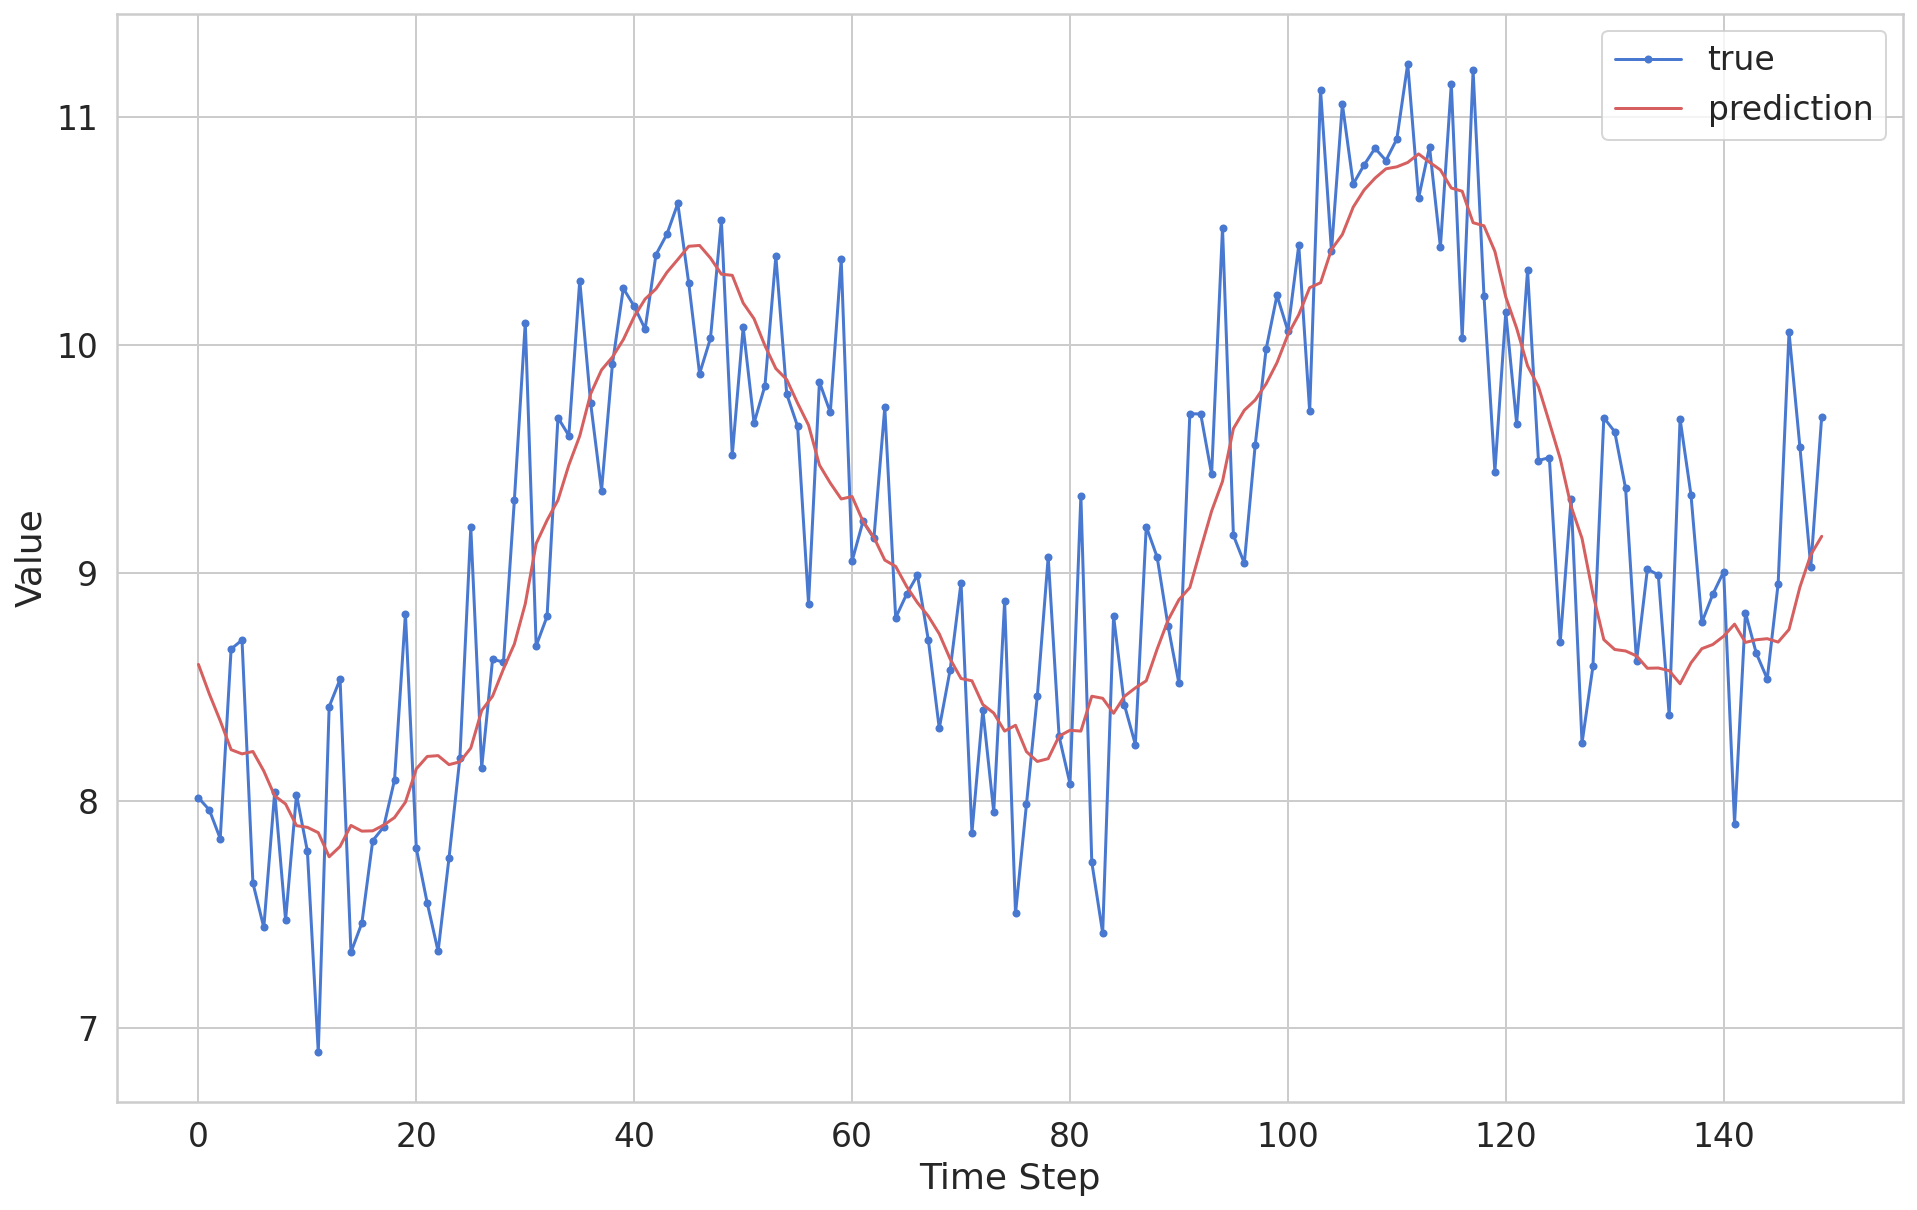

In [25]:
plt.plot(y_test, marker='.', label="true")
plt.plot(y_pred, 'r', label="prediction")
plt.ylabel('Value')
plt.xlabel('Time Step')
plt.legend()
plt.show();